# Downloading The Data
The data for this project is Downloaded from kaggle(A Famous platform for Data Sience), If you want to reproduce this note book follow the steps explained in [this article](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/) .

After downloading your kaggle credentials, upload the kaggle.json file to your google drive in a folder called kaggle.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/My Drive/Kaggle/kaggle.json' kaggle.json

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets download -d saurabhshahane/ecommerce-text-classification

In [ ]:
! unzip /content/ecommerce-text-classification.zip -d /content/data

# Introduction
In this note book we will fine tune a text classification **Bert** model on an **Ecomerce category data**.
We have 4 Categories, **Electronics**, **Household**, **Books** and **Clothing & Accessories**.

### Metrics
We'll use **Precision**, **Recall**, **F1-score** and **Accuracy**.

### Strategy Overview
The main library used in this notebook is **transormers** form **Hugging Face**, The framework is **TensorFlow** and we are fine tuning the **distilbert-base-uncased** model form **Hugging Face** which is a text classification model.

# Packages

We'll install Theses packages:


*   **datasets** for importing the data to transformers.
*   **transformers** that provides a variety of NLP functionality.
*   **evaluate** for model evalution.
*   **seqeval** for the metrics used for evaluation.
*   **seaborn** for data visualisation.





In [ ]:
! pip install datasets
! pip install transformers
! pip install evaluate
! pip install seqeval

In [ ]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

## Missing Values

Our data has 2 columns, **label** and **text**.

In [ ]:
dataset_df = pd.read_csv("/content/data/ecommerceDataset.csv")
dataset_df = pd.DataFrame({'label': dataset_df.iloc[:,0] , 'text': dataset_df.iloc[:,1]})
dataset_df.head()

label                                               text
0  Household  SAF 'Floral' Framed Painting (Wood, 30 inch x ...
1  Household  SAF 'UV Textured Modern Art Print Framed' Pain...
2  Household  SAF Flower Print Framed Painting (Synthetic, 1...
3  Household  Incredible Gifts India Wooden Happy Birthday U...
4  Household  Pitaara Box Romantic Venice Canvas Painting 6m...

Let's see how much of our data is missing.

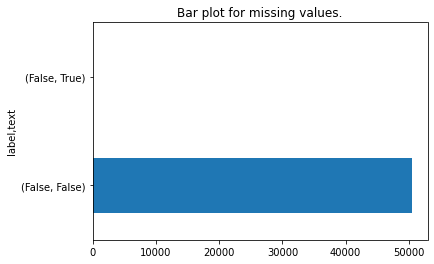

In [ ]:

dataset_df.isna().value_counts().plot(kind='barh', title='Bar plot for missing values.')
plt.show()

As we can see, there's just one missing value so will simply drop it.

In [ ]:
dataset_df.dropna(inplace=True)

## Data Transformation

In this task we have 4 Categories, **Electronics**, **Household**, **Books** and **Clothing & Accessories**. We'll encode the categorical variable **label** using label encoding. 




In [ ]:
mapping = {"Electronics": 0, "Household": 1, "Books": 2, "Clothing & Accessories": 3}
dataset_df.replace(mapping, inplace=True)

Now we'll use the **datasets** library to convert the data to a **transformers** compatible format. also we'll split the data to **train** and **test** splits, the **test** split is 30% of the total data.

In [ ]:
from datasets import Dataset
dataset = Dataset.from_pandas(dataset_df, split='train')
dataset = dataset.train_test_split(test_size=0.3)

Let's take a look at an example from the train set.

In [ ]:
dataset['train'][1000]

{'label': 1,
 'text': 'SEECO SE-2001C Rear Footrest for Royal Bullet Classic SEECO SE-2001C Rear Footrest for Royal Bullet Classic.',
 '__index_level_0__': 2730}

Now we'll use the appropriate Tokenizer and Collator for our task. padding is also required for batching.

In [ ]:
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess_function(examples):
  return tokenizer(examples["text"], truncation=True)

tokenized_ds = dataset.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

  0%|          | 0/36 [00:00<?, ?ba/s]

  0%|          | 0/16 [00:00<?, ?ba/s]

# Model Definition And Training

In this notebook we'll use the **distilbert-base-uncased** model from **Hugging Face**.

In [ ]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

id2label = {0: "Electronics", 1: "Household", 2: "Books", 3: "Clothing & Accessories"}
label2id = {"Electronics": 0, "Household": 1, "Books": 2, "Clothing & Accessories": 3}

model = TFAutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id
)

Now we prepare the data using the data collator.

In [ ]:
tf_train_set = model.prepare_tf_dataset(
    tokenized_ds["train"],
    shuffle=True,
    batch_size=16,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    tokenized_ds["test"],
    shuffle=False,
    batch_size=16,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Now we'll create the optimzer and we'll be ready to compile our model.

In [ ]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_ds["train"]) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

model.compile(optimizer=optimizer)

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


It's time for training our model, but first we need to login to **Hugging Face** so we can push our model.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers.keras_callbacks import PushToHubCallback

callback = PushToHubCallback(output_dir="e-comerce-category-classification"
                                , tokenizer=tokenizer
                             )

model.fit(x=tf_train_set, 
          validation_data=tf_validation_set,
          callbacks=[callback],
          epochs=3)

Let's test our model with a simple example.

In [ ]:
inputs = tokenizer('I want to sell a laptop')
model_inputs = tf.constant(inputs['input_ids'])
outputs = model(model_inputs)

predictions = tf.math.softmax(outputs.logits, axis=-1)
model.config.id2label[tf.math.argmax(tf.squeeze(predictions)).numpy()]

'Electronics'

I will save the weights for the future in my google drive.

In [ ]:
model.save_pretrained("/content/saved_model")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/saved_model.zip' /content/gdrive/MyDrive/saved_models

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Evaluation

Let's copy our wieghts form my google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!cp '/content/gdrive/MyDrive/saved_models/saved_model.zip' /content

In [ ]:
! unzip /content/saved_model.zip -d /content/model

Here, We're loading the weights to our model.

In [ ]:
model = model.from_pretrained('/content/model')

Some layers from the model checkpoint at /content/model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_39']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /content/model and are newly initialized: ['dropout_119']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We have trained our model, and now we are ready for the **Evaluation**.

In [ ]:
import evaluate

metric = evaluate.load("seqeval")

We'll simply use our model to predict the labels for the test set. then we'll use **precision**, **recall**, **f1-score** and **accuracy** to evaluate our model.

In [ ]:
import numpy as np

all_predictions = []
all_labels = []

for batch in tf_validation_set:
    logits = model.predict_on_batch(batch)["logits"]
    labels = batch[1]
    predictions = np.argmax(logits, axis=-1)
    for prediction, label in zip(predictions, labels):
      all_predictions.append(id2label[prediction])
      all_labels.append(id2label[label.numpy()])

metric.compute(predictions=[all_predictions], references=[all_labels])

/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Household seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Clothing & Accessories seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Books seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.8/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: Electronics seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'lectronics': {'precision': 0.9801796221740476,
  'recall': 0.9912308174130912,
  'f1': 0.9856742447835565,
  'number': 3193},
 'lothing & Accessories': {'precision': 0.989843028624192,
  'recall': 0.9912159038372631,
  'f1': 0.9905289905289906,
  'number': 2163},
 'ooks': {'precision': 0.9959862385321101,
  'recall': 0.9866515194547004,
  'f1': 0.9912969039805964,
  'number': 3521},
 'ousehold': {'precision': 0.9735228539576366,
  'recall': 0.9710870169585766,
  'f1': 0.9723034098816979,
  'number': 3597},
 'overall_precision': 0.9843637238393071,
 'overall_recall': 0.9841269841269841,
 'overall_f1': 0.9842453397474443,
 'overall_accuracy': 0.990348383684802}

# Conclusion
We had pretty good results in this notebook. all the metrics are above 98%.

| Syntax      | Description |
| ----------- | ----------- |
| Precision      | 0.98       |
| Recall   | 0.98        |
| F1-score   | 0.98        |
| Accuracy   | 0.99        |